# **Alcohol Violation in Fatal Crashes**

While use of alcohol and the risks posed by alcohol for drivers have been well known for many decades, and many effort have been put in educating the public and making policy to prevent people from drunk driving, alcohol involvement is still one of the major factor which causes fatal accidents.<br/>

In our notebook1, *Logistic Regression of Fatal Accidents*, we found a statistically significant association between alcohol involvement and fatal accidents. In this notebook, we want to analyze characteristics of alcohol-related crashes*, such as:<br/>
- Trend of alcohol-related crashes
- Which group of people (by state, age, and gender) are most likely to involve in alcohol-related crashes
- Whether alcohol contributes to other dangerous actions such as speeding

*Note: alcohol-related crashes refers to driver who classified as drinking (alcohol-involved) if the driver has (1) police-reported alcohol involvement, or (2) a positive alcohol test result. <br/> Source: *Fatality Analysis Reporting
System (FARS) Analytical User’s Manual*

In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas import DataFrame
import seaborn as sns
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_columns', 100)

### Load data 
**accidents**: The Accident data file includes crash data from 2007 to 2016, where the "CASE_NUM" element is a unique fatal accident.<br/>
**person**: The person data file includes information of who involved in fatal accidents from 2007 to 2016, and it contains variables such as age and gender.<br/>
**vehicles**:The Vehicle data file includes in-transport motor vehicle data as well as driver and precrashm data from 2007 to 2016.

In [2]:
accidents = pd.read_hdf('results/accidents.h5', 'accidents')
accidents16 = pd.read_hdf('results/accidents16.h5', 'accidents16')
person = pd.read_hdf('results/person.h5', 'person')
vehicles=pd.read_hdf('results/vehicles.h5', 'vehicles')
fatal_crashs = pd.merge(vehicles, accidents, left_index=True, right_index=True, how='inner',on=('STATE', 'YEAR','CASE_NUM'))
fatal_crashs_all = pd.merge(fatal_crashs, person, how='inner',on=('STATE', 'YEAR','CASE_NUM'))

To begin with, let's get a sence of the proportion of alcohol-related fatal accidents in all fatal accidents.

In [3]:
accidents.head()

,YEAR,CASE_NUM,STATE,NUM_VEHICLE,FATALS,MONTH,DAY_WEEK,HOUR,HIGHWAY,LATITUDE,LONGITUD,COLLISION_TYPE,LIGHT_CONDITION,WEATHER,CRASH_FACTOR,DRUNK_DRIVE
200710001,2007,10001,1,1.0,1.0,January,Tuesday,23.0,Off,33.455839,-87.017928,Not Collision,Dark,Clear,0.0,0.0
200710002,2007,10002,1,3.0,2.0,January,Tuesday,13.0,Off,34.160597,-85.678075,"Sideswipe, Same Direction",Daylight,Clear,0.0,0.0
200710003,2007,10003,1,2.0,1.0,January,Sunday,12.0,Off,33.975717,-86.496347,"Sideswipe, Unknown Direction",Daylight,Clear,0.0,0.0
200710004,2007,10004,1,2.0,1.0,January,Monday,15.0,On,33.853258,-85.915622,Angle,Daylight,Clear,0.0,0.0
200710005,2007,10005,1,2.0,1.0,January,Saturday,19.0,Off,32.488833,-86.408936,"Sideswipe, Same Direction",Dark,Clear,0.0,0.0


In [4]:
#"DRUNK_DRIVE" records numbers of drinking drivers in fatal accidents, 0 represents no alcohol involvement. 
1-len(accidents.loc[accidents['DRUNK_DRIVE']== 0])/len(accidents)

0.3095015488945817

From 2007 to 2016, about 31% of fatal accidents involved alcohol. <br/>
To identify the trend of alcohol-related fatal accidents, we grouped the accidents by year and sum up number of fatal accidents in each year.

# Part 1
# Alcohol-Involved Fatal Accidents Trend

In [5]:
# add a drinking indicator column in accidents table. 1 represents drinking, 0 represents nondrinking.
accidents['DRUNK_INDICATOR']=accidents['DRUNK_DRIVE'].where(accidents['DRUNK_DRIVE'] <= 1, 1)

# group accidents by year to get the total number of fatal accidents and total number of alcohol-involved fata accidents. 
Death_by_year = accidents.groupby('YEAR',as_index=False)['FATALS'].sum()
Death_by_year_Alcohol = accidents[accidents.DRUNK_DRIVE == 1].groupby('YEAR',as_index=False)['FATALS'].sum()
Death_by_year['Fatal_Involved_Alcohol']= Death_by_year_Alcohol['FATALS']
Death_by_year

,YEAR,FATALS,Fatal_Involved_Alcohol
0,2007,41259.0,12942.0
1,2008,37423.0,11900.0
2,2009,33883.0,10812.0
3,2010,32999.0,10233.0
4,2011,32479.0,9876.0
5,2012,33782.0,10206.0
6,2013,32893.0,9835.0
7,2014,32744.0,9443.0
8,2015,35485.0,9900.0
9,2016,37461.0,9412.0


### Plot total number of fatal accidents and total number of alcohol-involved fatal accidents by year

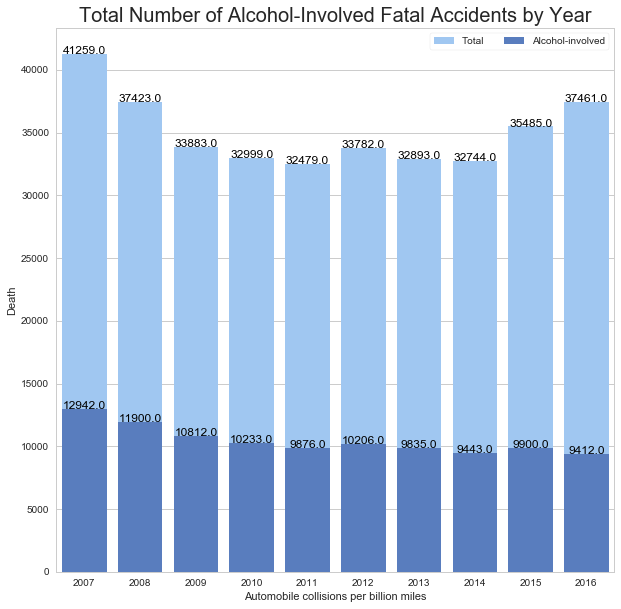

In [6]:
f, g = plt.subplots(figsize=(10, 10))
# Plot the total deadth
sns.set_color_codes("pastel")
g = sns.barplot(x="YEAR",y="FATALS",data=Death_by_year,label="Total", color="b")
# Plot the total deadth where alcohol was involved
sns.set_color_codes("muted")
g = sns.barplot(x="YEAR", y="Fatal_Involved_Alcohol", data=Death_by_year,
            label="Alcohol-involved", color="b")
# Add a legend and informative axis label
g.legend(ncol=2, frameon=True)
g.set( ylabel="Death",xlabel="Automobile collisions per billion miles")
g.set_title("Total Number of Alcohol-Involved Fatal Accidents by Year",size=20)
for index, row in Death_by_year.iterrows():
    g.text(row.name,row.FATALS, round(row.FATALS,2),color='black', ha="center")
    g.text(row.name,row.Fatal_Involved_Alcohol, round(row.Fatal_Involved_Alcohol,2),color='black', ha="center")
plt.show()

From graph above, we can see that total number of fatal accidents decreased from 2017 to 2012, but later increase since 2012, alcohol-involved fata accidents reduced significantly and there seems to be a downward trend of total alcohol-related accidents.<br/>
To futher identify the trend of total alcohol-related accidents, we calculate and draw the growth rate of fatal accidents in the graph below.

### Plot growth rate by year

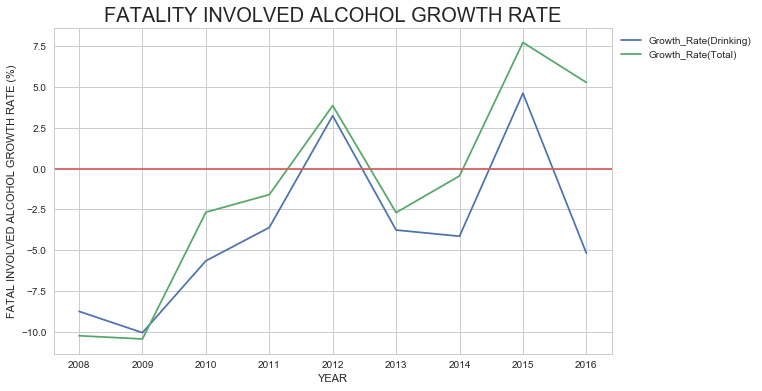

In [7]:
# calculate growth rate of total fatal accidents and alcohol-involved fatal accidents
Death_by_year['Growth_Rate(Drinking)']  = (np.diff(Death_by_year['Fatal_Involved_Alcohol'])/Death_by_year['Fatal_Involved_Alcohol'][1:])*100
Death_by_year['Growth_Rate(Total)']  = (np.diff(Death_by_year['FATALS'])/Death_by_year['FATALS'][1:])*100

# Plot growth rates
plt.plot(Death_by_year['YEAR'], Death_by_year['Growth_Rate(Drinking)'])
plt.plot(Death_by_year['YEAR'], Death_by_year['Growth_Rate(Total)'])

# Add a legend and informative axis label
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.title("FATALITY INVOLVED ALCOHOL GROWTH RATE",size=20)
plt.xlabel('YEAR')
plt.ylabel('FATAL INVOLVED ALCOHOL GROWTH RATE (%)')
plt.axhline(y=0, color='r')
plt.show()

Observed from the FATALITY INVOLVED ALCOHOL GROWTH RATE graph, in the year of 2013, 2014, 2016 and from 2008 to 2011, the total alcohol-involved fatal accidents decreased, and at the year of 2012 and 2015, total alcohol-involved fatal accidents increased.

# Part 2
# Explore Alcohol-Involved Fatal Accidents by Group

In part 2, We want explore 
- in which state people are more likely to involve in drunk driving
- which age group has the highest proportion of drunk drivers
- whether female or male are more likely to involve in drunk driving. 

## Alcohol-Involved Fatal Accidents by State

First we sum the fatal accidents in 2015 by state to get a sense of which state has drunk drivers the most.

In [8]:
#load accidents in 2015 and create a drunk index column in the table
accidents15 = pd.read_hdf('results/accidents15.h5', 'accidents15')
accidents15['DRUNK_INDICATOR']=accidents15['DRUNK_DR'].where(accidents15['DRUNK_DR'] <= 1, 1)

#group death by state
Death_by_state15=accidents15.groupby('STATE',as_index=False)['FATALS'].sum()
Death_by_state_alcohol15 =accidents15[accidents15.DRUNK_DR == 1].groupby('STATE',as_index=False)['FATALS'].sum()
Death_by_state15['Fatal_Involved_Alcohol']= Death_by_state_alcohol15['FATALS']

# map state name to state number
Death_by_state15['STATE_NAME']=Death_by_state15['STATE'].map({ 1: 'Alabama', 31: 'Nebraska',2: 'Alaska' ,32:'Nevada',4: 'Arizona' ,33 :'New Hampshire',5: 'Arkansas' ,34 :'New Jersey',6 :'California' ,35 :'New Mexico',8 :'Colorado' ,36 :'New York',9 :'Connecticut' ,37 :'North Carolina',10: 'Delaware' ,38 :'North Dakota',11: 'District of Columbia', 39 :'Ohio',12 :'Florida' ,40 :'Oklahoma',13 :'Georgia' ,41: 'Oregon',15 :'Hawaii' ,42: 'Pennsylvania',16 :'Idaho' ,43 :'Puerto Rico',17 :'Illinois' ,44 :'Rhode Island',18 :'Indiana ',45 :'South Carolina',19 :'Iowa' ,46 :'South Dakota',20 :'Kansas' ,47 :'Tennessee',21 :'Kentucky' ,48 :'Texas',22 :'Louisiana',49 :'Utah',23 :'Maine' ,50 :'Vermont',24:'Marland', 52: 'Virgin Islands (since 2004)',25 :'Massachusetts' ,51: 'Virginia',26 :'Michigan' ,53 :'Washington',27 :'Minnesota' ,54 :'West Virginia',28 :'Mississippi' ,55 :'Wisconsin',29 :'Missouri' ,56 :'Wyoming',30 :'Montana'})

# sort death value from the highest to the lowest
Death_by_state15_sort =Death_by_state15.sort_values("FATALS", ascending=False)
Death_by_state15_sort.head()

,STATE,FATALS,Fatal_Involved_Alcohol,STATE_NAME
43,48,3582,918,Texas
4,6,3387,1027,California
9,12,2938,685,Florida
10,13,1432,312,Georgia
33,37,1379,431,North Carolina


### Plot Total Fatality and Total Alcohol-Involved Fatality by State

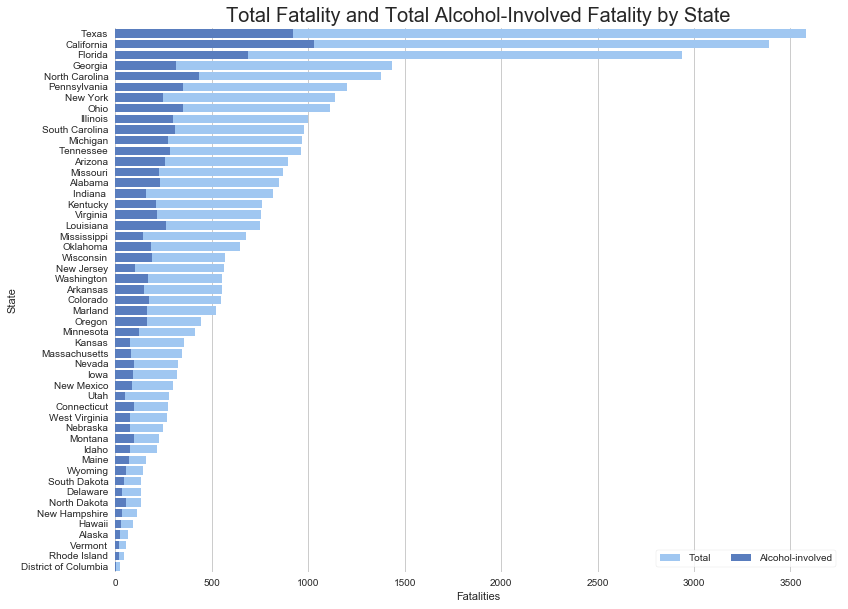

In [9]:
f, g = plt.subplots(figsize=(13, 10))
# Plot the total deadth
sns.set_color_codes("pastel")
g = sns.barplot(x="FATALS",y="STATE_NAME",data=Death_by_state15_sort,label="Total", color="b")

# Plot the total alcohol-involved fatality
sns.set_color_codes("muted")
g = sns.barplot(x="Fatal_Involved_Alcohol", y="STATE_NAME", data=Death_by_state15_sort,
            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
g.set( ylabel="State",xlabel="Fatalities")
g.set_title("Total Fatality and Total Alcohol-Involved Fatality by State",size=20)
g.legend(ncol=2, frameon=True)
sns.despine(left=True, bottom=True)
plt.show()

Taxes, California, Florida has the most fatalities, and they also has the most alcohol-involved fatalities. <br/>
To better understand the role of alcohol, it is useful to compare drinking and nondrinking drivers in fatal crashes. Therefore, we calculate the percentage of drivers who involved in alcohol-related fatal accidents by state.

*source: total number of licensed drivers : [U.S Department of Transportation, Federal Highway Administration](https://www.fhwa.dot.gov/policyinformation/statistics/2015/dl1c.cfm)



### Plot Proportion of Drivers Involved in Alcohol-Related Fatal Accidents by State

In [10]:
# load data contains numbers of licensed drivers in each states
licensed_drivers_by_states = pd.read_csv('data/licensed_drivers_by_states.csv')
Prop_drivers_accident15 =Death_by_state15.merge(licensed_drivers_by_states.drop('STATE_NAME',1), on='STATE', how='left')

# calculate percentage of drivers who involved in alcohol-related fatal accidents
Prop_drivers_accident15['FATALS_ALOCOHOL_PROPORTION']=(Prop_drivers_accident15['Fatal_Involved_Alcohol']/Prop_drivers_accident15['TOTAL'])*100

# sort percentage from the highest to the lowest
Prop_drivers_accident15_sort =Prop_drivers_accident15.sort_values("FATALS_ALOCOHOL_PROPORTION", ascending=False)
Prop_drivers_accident15_sort.head()

,STATE,FATALS,Fatal_Involved_Alcohol,STATE_NAME,TOTAL,FATALS_ALOCOHOL_PROPORTION
50,56,145,56,Wyoming,422450,0.013256
26,30,224,95,Montana,781427,0.012157
34,38,131,56,North Dakota,545027,0.010275
40,45,979,309,South Carolina,3683824,0.008388
18,22,752,263,Louisiana,3357091,0.007834


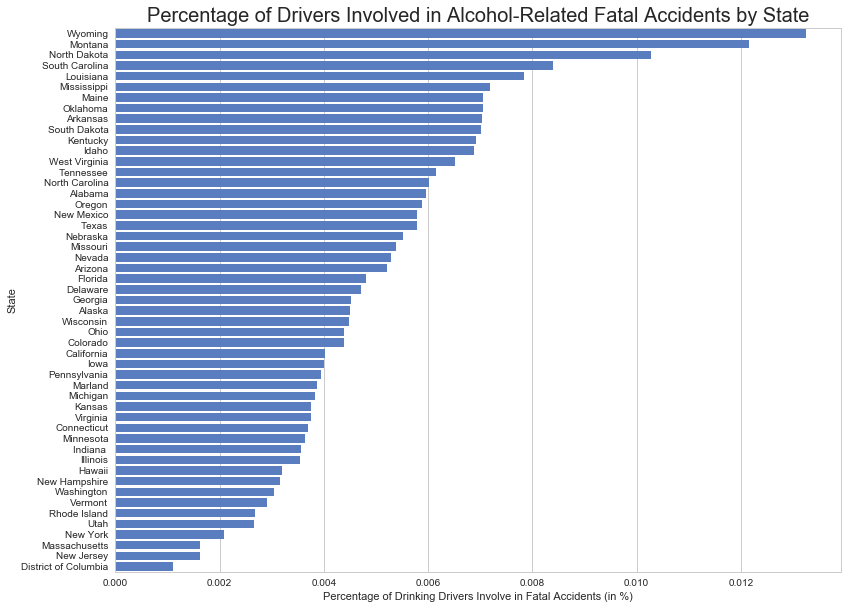

In [11]:
f, g = plt.subplots(figsize=(13, 10))
# Plot the percentage of drivers who involved in alcohol-related fatal accidents
g = sns.barplot(x="FATALS_ALOCOHOL_PROPORTION", y="STATE_NAME", data=Prop_drivers_accident15_sort,label="Alcohol-involved", color="b")

# Add a legend and informative axis label
g.set( ylabel="State",xlabel="Percentage of Drinking Drivers Involve in Fatal Accidents (in %)")
g.set_title("Percentage of Drivers Involved in Alcohol-Related Fatal Accidents by State",size=20)
plt.show()

Altough Taxes, California, and Florida have the most fatalities and alcohol-involved fatalities, they do not have the highest drinking driver ratio. After taking the state population into account, we found that even though california has high fatalites, drivers in california are less likely to involved in alcohol-related fatal accidents compared to other states. In contrast, Wyoming, Montana, and North Dakota are some of the states with the least alcohol-involved fatal accidents, but drivers in Wyoming, Montana, and North Dakota are the most likely to involve in drunk driving.

## Alcohol-Involved Fatal Accidents by Age

In [12]:
#group fatal accidents by age, calculate total fatilites 
Death_by_age_drinking=fatal_crashs_all.loc[fatal_crashs_all['DRINKING_INDICATOR'] == 1].loc[fatal_crashs_all['AGE']<=98].loc[fatal_crashs_all['AGE']>=16].groupby('AGE',as_index=False)['FATALS'].sum()
Death_by_age_drinking.rename(columns={'FATALS':'Fatal_Involved_Alcohol'},inplace=True)
#group fatal accidents by age, calculate total alcohol-invloved fatilites 
Death_by_age_nondrinking=fatal_crashs_all.loc[fatal_crashs_all['DRINKING_INDICATOR'] == 0].loc[fatal_crashs_all['AGE']<=98].loc[fatal_crashs_all['AGE']>=16].groupby('AGE',as_index=False)['FATALS'].sum()
Death_by_age_drinking['Fatal_No_Alcohol']= Death_by_age_nondrinking['FATALS']
Death_by_age_drinking.head()

,AGE,Fatal_Involved_Alcohol,Fatal_No_Alcohol
0,16.0,3589.0,25749.0
1,17.0,5287.0,33010.0
2,18.0,8194.0,41790.0
3,19.0,9093.0,37919.0
4,20.0,9752.0,40241.0


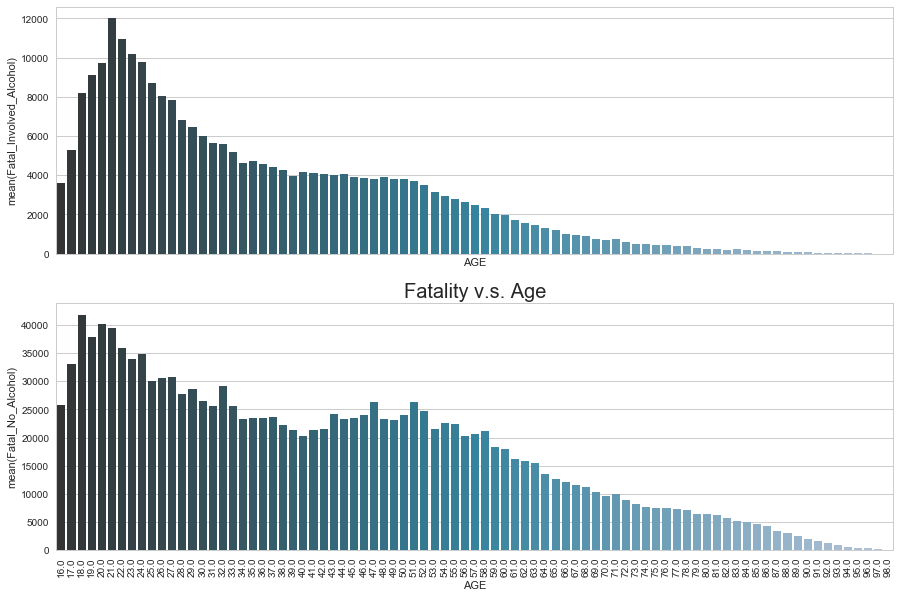

In [13]:
# plot deaths v.s. age
fig, (ax1, ax2) = plt.subplots(2,sharex=True,figsize=(15, 10))
g = sns.barplot(x="AGE", y="Fatal_Involved_Alcohol", data=Death_by_age_drinking,label="Total",palette="PuBuGn_d",ax=ax1)
g = sns.barplot(x="AGE", y="Fatal_No_Alcohol", data=Death_by_age_drinking,label="Total",palette="PuBuGn_d",ax=ax2)
# Add a legend and informative axis label
g.set_title("Fatality v.s. Age",size=20)
plt.xticks(rotation='vertical')
plt.show()

We can see that in both nondrinking fatal accidents and drinking fatal accidents, young people who in their 20s are the most likely to involve in fatal accidents. 
<br/>
However, it is obvious that age group in nondrinking fatal accidents are more spread out, and the proportion of young people involve in drinking fatal accidents is significantly larger than other age group. Therefore, we come to the conclusion that young people who in their 20s are the most likely to involve in both non drinking fatal accidents and drinking fatal accidents. The common explanation for this relationship is the inexperience and risk-taking of youthful drivers and the deterioration of driving skills.

## Alcohol-Involved Fatal Accidents by Gender

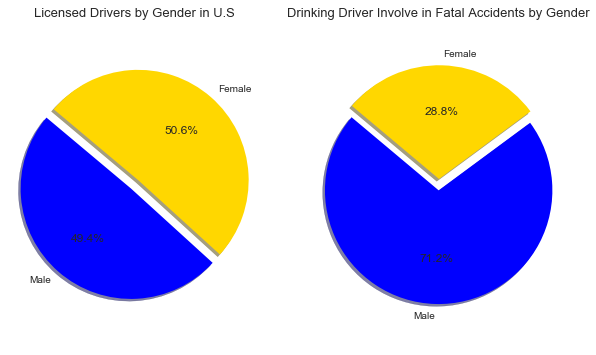

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)
labels = 'Male', 'Female'
colors = [ 'blue','gold']
explode = (0.1, 0)  # explode 1st slice

drivers_by_gender = [107649686, 110434779] # data souce: U.S Department of Transportation, Federal Highway Administration
driking_by_gender = [fatal_crashs_all.query('DRINKING_INDICATOR == 1 and SEX == 1 and YEAR==2015')['CASE_NUM'].count(),fatal_crashs_all.query('DRINKING_INDICATOR == 1 and SEX == 2and YEAR==2015')['CASE_NUM'].count()]
# Plot1
ax1.pie(drivers_by_gender, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
ax1.axis('equal')
ax1.set_title("Licensed Drivers by Gender in U.S",size =13)
# plot2
ax2.pie(driking_by_gender, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
ax2.axis('equal')
ax2.set_title("Drinking Driver Involve in Fatal Accidents by Gender",size =13)

plt.show()

In 2015, there are *110,434,119* licensed male drivers and *107,649,686* licensed female drivers in the U.S. In other words, male and female take about 50% of driver population. However, in alcohol-involved fatal accidents, 71.2% of drinking drivers are male, and only 28.8% of drinking drivers are female. These statistic show that male are much more likely to involve in alcohol-related fatal accidents.
<br/> *source: [U.S Department of Transportation, Federal Highway Administration](https://www.fhwa.dot.gov/policyinformation/statistics/2015/dl1c.cfm)



# Part 3
# Explore If Drinking Encourage Speeding

In [15]:
"""since data before 2009 do not contain information of whether the driver speeding or not, 
so we select data from after 2009"""

fatal_crashs_since2009=fatal_crashs_all.loc[fatal_crashs_all['YEAR'] >= 2009]

""" since dataset contains not only vehicles but also other transportations such as trains, 
we exclueded trains by limiting the speed to 200 (usually cars have 180 mph limit)"""

no_trains=fatal_crashs_since2009[(fatal_crashs_since2009.SPEED <= 200)& (fatal_crashs_since2009.SEX <= 2)]
no_trains.head()

,STATE,YEAR,CASE_NUM,SPEED,ROLLOVER,FIRE,BODY_TYP,SPEEDING,DEATHS,DRINKING_INDICATOR,NUM_VEHICLE,FATALS,MONTH,DAY_WEEK,HOUR,HIGHWAY,LATITUDE,LONGITUD,COLLISION_TYPE,LIGHT_CONDITION,WEATHER,CRASH_FACTOR,DRUNK_DRIVE,AGE,SEX,RACE
354130,10,2009,100001,50.0,0.0,0.0,Sedan,1.0,1.0,0.0,1.0,1.0,January,Saturday,1.0,Off,39.6102,-75.7064,Not Collision,Dark,Clear,0.0,0.0,33.0,1.0,1.0
354131,10,2009,100001,50.0,0.0,0.0,Sedan,1.0,1.0,0.0,1.0,1.0,January,Saturday,1.0,Off,39.6102,-75.7064,Not Collision,Dark,Clear,0.0,0.0,29.0,2.0,0.0
354132,10,2009,100002,50.0,0.0,0.0,Sedan,0.0,2.0,0.0,2.0,2.0,January,Saturday,16.0,Off,39.6752,-75.7040,"Sideswipe, Same Direction",Daylight,Clear,0.0,0.0,71.0,2.0,1.0
354133,10,2009,100002,50.0,0.0,0.0,Sedan,0.0,2.0,0.0,2.0,2.0,January,Saturday,16.0,Off,39.6752,-75.7040,"Sideswipe, Same Direction",Daylight,Clear,0.0,0.0,70.0,1.0,1.0
354134,10,2009,100002,50.0,0.0,0.0,Sedan,0.0,2.0,0.0,2.0,2.0,January,Saturday,16.0,Off,39.6752,-75.7040,"Sideswipe, Same Direction",Daylight,Clear,0.0,0.0,41.0,1.0,0.0


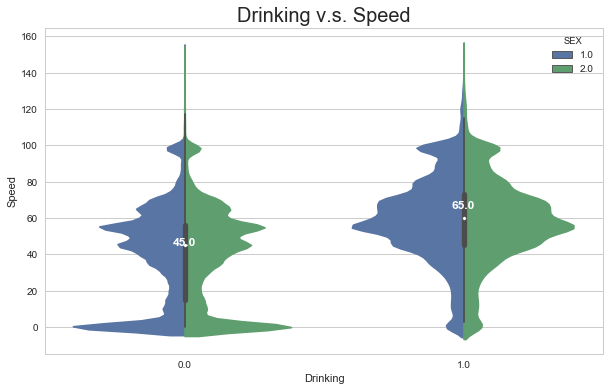

In [16]:
# plot drinking driver speed and non drinking driver speed and plot each group by gender
g = Drunk_Speeding=sns.violinplot(data=no_trains, x="DRINKING_INDICATOR", y="SPEED",
               hue="SEX", split=True)

# Add a legend and informative axis label
g.set( ylabel="Speed",xlabel="Drinking")
g.set_title("Drinking v.s. Speed",size=20)

# get median of drinking group and non drinking group 
medians = no_trains.groupby(['SPEEDING'])['SPEED'].median().values
median_labels = [str(np.round(s, 2)) for s in medians]
pos = range(len(medians))
for tick,label in zip(pos,Drunk_Speeding.get_xticklabels()):
   Drunk_Speeding.text(pos[tick], medians[tick] + 0.05, median_labels[tick], horizontalalignment='center', color='w', weight='semibold')
plt.show()

Observed from graph above, drinking drivers have median speed of 65, and the median speed of non-drinking drivers is 45, which is lower than drinking drivers. However, there is no big different on speeding between male and female, in both drinking and nondrinking case. <br/>
In order to know whether drinking encourages speeding or not, we performed **two-sample-z-test** as below:<br/>
We denote nondrinking group group1, and drinking group2. Null hypothesis: there is no difference between these two groups, i.e :

$$H_0:\mu_2-\mu_1=0$$

compute test statistic:
$$Z=\frac{(\overline{X_2}-\overline{X_1})-(\mu_2-\mu_1)} {\sqrt[2]{(\hat{\sigma_2}^2/n_2+ \hat{\sigma_1}^2/n_1)}} $$

and compare it with Z = 1.96, where significant level, alpha=0.05. If Z > 1.96, that indicates two groups are statistically significantly different, which means that drinking encourage speeding.

In [17]:
def two_sample_test(null_samples, test_samples):
   # H0: mu2-mu1 =0
    x1= null_samples.mean()
    x2= test_samples.mean()
    var1 = np.var(null_samples)
    var2 = np.var(test_samples)
    n1 = len(null_samples)
    n2 = len(test_samples)
    test_stat = (x2-x1)/(var1/n1 + var2/n2)**(1/2)
    if test_stat > 1.96:
        return True
    else:
        return False

In [18]:
nondrinking = no_trains.loc[no_trains['SPEEDING'] == 0]['SPEED']
drinking = no_trains.loc[no_trains['SPEEDING'] == 1]['SPEED']
two_sample_test(nondrinking, drinking)

True

From the two sample z test, we can conclude that drinking increase driving speed significantly. Not only drinking makes people less sober, but it also encourages dangerous actions during driving such as speeding so that people are more likely to involve in fatal accidents.